<a href="https://colab.research.google.com/github/vinyas-bharadwaj/SkimLit-Medical-Abstract-Classifier-/blob/main/SkimLit_Medical_Abstracts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Dec 30 15:25:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Getting our data ready

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


### Starting with the 20k dataset (10% of total)

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preprocess data

In [ ]:
# Creating a function to read the lines of a document
def read_lines(filename):
  """
  Reads filename (.txt file) and returns a list of lines.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = read_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
def preprocess_text(filename):
  """
  Returns a list of dictionaries of abstract line data.
  """

  input_lines = read_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): # Check to see if line is a new line
      abstract_lines_split = abstract_lines.splitlines() # split abstract into seperate lines

      # Iterate through each line in a singular abstract and count them
      for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_lines_split) - 1
        abstract_samples.append(line_data)

    else: # If the above lines aren't executed, this means that we have a valid labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
%%time

train_samples = preprocess_text(data_dir + "train.txt")
val_samples = preprocess_text(data_dir + "dev.txt")
test_samples = preprocess_text(data_dir + "test.txt")

CPU times: user 712 ms, sys: 107 ms, total: 819 ms
Wall time: 1.31 s


In [ ]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
for sample in train_samples[:5]:
  print(sample)

{'target': 'OBJECTIVE', 'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .', 'line_number': 0, 'total_lines': 11}
{'target': 'METHODS', 'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .', 'line_number': 1, 'total_lines': 11}
{'target': 'METHODS', 'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .', 'line_number': 2, 'total_lines': 11}
{'target': 'METHODS', 'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .', 'line_number': 3, 'total_lines': 11}
{'target': 'METHODS', 'text': 'secondary outcome measures included the western ontario and mcmaster universities osteoar

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<Axes: ylabel='Frequency'>

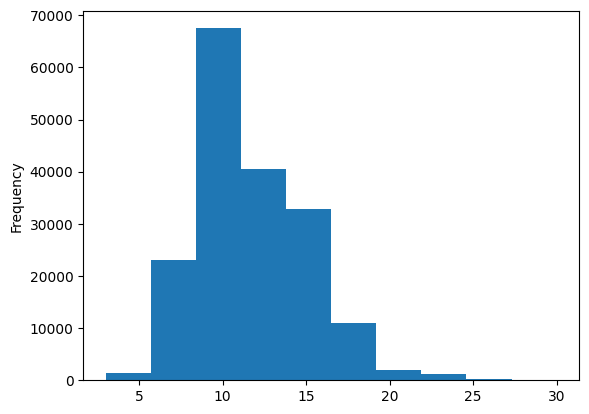

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Turning our labels into numbers

In [ ]:
# One hot encode our labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df[["target"]].to_numpy())
val_labels_one_hot = one_hot_encoder.transform(val_df[["target"]].to_numpy())
test_labels_one_hot = one_hot_encoder.transform(test_df[["target"]].to_numpy())

In [ ]:
# Extract labels ("target" column) and encode them into integers

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"])
val_labels_encoded = label_encoder.transform(val_df["target"])
test_labels_encoded = label_encoder.transform(test_df["target"])

In [ ]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
  ("tfidf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-30 15:25:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-30 15:25:55 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import *

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Average sentence length
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

Text(0, 0.5, 'Frequency')

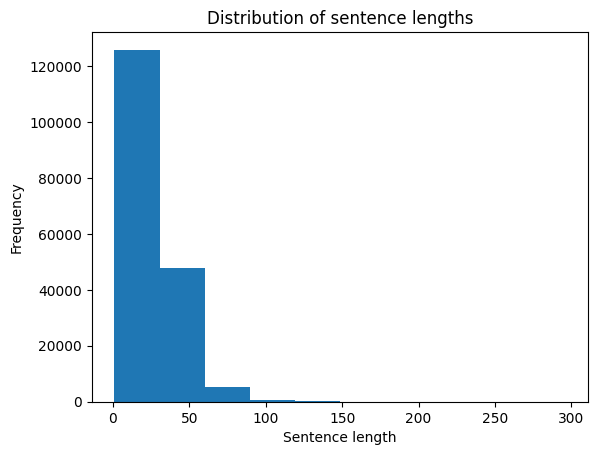

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens)
plt.title("Distribution of sentence lengths")
plt.xlabel("Sentence length")
plt.ylabel("Frequency")

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

## Creating a text vectorizer layer

In [ ]:
# Number of words in the vocab for pubmed-rct-20k is 68k, this is taken from the research paper
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # Number of words in vocab
                                    output_sequence_length=output_seq_len) # Desired length of vectorized output

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
import random

target_sentence = random.choice(train_sentences)
print(f"Text: {target_sentence}")
print(f"Length of sentence: {len(target_sentence.split())}")
print(f"Vectorized: {text_vectorizer([target_sentence])}")

Text: this study was a blinded clinical trial with randomized groups .
Length of sentence: 11
Vectorized: [[ 23  17  10   8 587  47  32   7  29  24   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")

Number of words in vocab: 64841


In [ ]:
rct_20k_text_vocab[:10] # 10 most common words

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

## Creating a word embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim=len(rct_20k_text_vocab), # Length of our vocabulary
                        output_dim=128,
                        mask_zero=True, # Use masking to handle variable sequence length
                        name="token_embedding")

In [ ]:
print(f"Text:\n {target_sentence}\n")
print(f"Vectorized:\n {text_vectorizer([target_sentence])}\n")
print(f"Embedded:\n {token_embed(text_vectorizer([target_sentence]))}\n")
print(f"Embedded sentence shape:\n{token_embed(text_vectorizer([target_sentence])).shape}")

Text:
 this study was a blinded clinical trial with randomized groups .

Vectorized:
 [[ 23  17  10   8 587  47  32   7  29  24   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Embedded:
 [[[-0.0384443   0.03756573 -0.01692637 ...  0.00743173  0.04914233
   -0.02761209]
  [ 0.01683475  0.00174002 -0.04949862 ...  0.00526062  0.00978307
    0.00225485]
  [-0.04864703  0.02535954  0.04672645 ...  0.03926985  0.04930686
   -0.03015168]
  ...
  [ 0.02302991 -0.00190067  0.03999313 ...  0.01985181 -0.01547924
   -0.04256941]
  [ 0.02302991 -0.00190067  0.03999313 ...  0.01985181 -0.01547924
   -0.04256941]
  [ 0.02302991 -0.00190067  0.03999313 ...  0.01985181 -0.01547924
   -0.04256941]]]

Embedded sentence shape:
(1, 55, 128)


## Turning our data into TensorFlow Datasets (Making sure our data loads as fast as possible)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the tensor sliced datasets and turn them into prefetched data (Faster computation)

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token emvbeddings

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype="string")
text_vectorized = text_vectorizer(inputs)
embedded = token_embed(text_vectorized)
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(embedded)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        epochs=10,
                        validation_data=valid_dataset,
                        validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5613 - loss: 1.0995 - val_accuracy: 0.7829 - val_loss: 0.5856
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7876 - loss: 0.5921 - val_accuracy: 0.8015 - val_loss: 0.5272
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7942 - loss: 0.5489 - val_accuracy: 0.8072 - val_loss: 0.5109
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8063 - loss: 0.5260 - val_accuracy: 0.8138 - val_loss: 0.4993
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8060 - loss: 0.5353 - val_accuracy: 0.8218 - val_loss: 0.4860
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8045 - loss: 0.5253 - val_accuracy: 0.8278 - val_loss: 0.4819
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8157 - loss: 0.4909 - val_accuracy: 0.8221 - val_loss: 0.4832
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8242 - loss: 0.4817 - val_accuracy: 0

In [ ]:
model_1.evaluate(test_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8179 - loss: 0.4941


[0.4894471764564514, 0.8195785880088806]

In [ ]:
conv1d_preds = model_1.predict(test_dataset)
conv1d_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=conv1d_preds.argmax(axis=1))
conv1d_results

942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


{'accuracy': 81.95785631325701,
 'precision': 0.8150727878865605,
 'recall': 0.81957856313257,
 'f1': 0.8158965133833758}

## Model 2: Feature extraction with word embeddings

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
embed

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7e9d9710a950>

In [ ]:
embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                 trainable=False,
                                 name="universal_sentence_encoder")

In [ ]:
embedding_layer([target_sentence]).shape

TensorShape([1, 512])

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Create the hub layer
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    name="universal_sentence_encoder"
)

class EmbeddingLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.use_layer = use_layer

    def call(self, inputs):
        return self.use_layer(tf.squeeze(tf.cast(inputs, tf.string)))

# Create the model
inputs = layers.Input(shape=(1,), dtype="string")
embedding_layer = EmbeddingLayer()
embedded = embedding_layer(inputs)
x = layers.Dense(128)(embedded)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_use")

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
model_2.fit(train_dataset, steps_per_epoch=int(0.1 * len(train_dataset)), epochs=5, validation_data=valid_dataset, validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_55250[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, _output_shapes=[[32]], _user_specified_name="data", index=0){{node data}}
The op is created at: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-53-ee88e6e88171>", line 1, in <cell line: 1>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>
	tf2xla conversion failed while converting __inference_one_step_on_data_55250[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_55651]

In [ ]:
model_2.evaluate(test_dataset)

InvalidArgumentError: Graph execution error:

Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_56153[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, _output_shapes=[[32]], _user_specified_name="data", index=0){{node data}}
The op is created at: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-54-78ff74969c4d>", line 1, in <cell line: 1>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 433, in evaluate
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>
	tf2xla conversion failed while converting __inference_one_step_on_data_56153[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_56534]

In [ ]:
model_2_preds = model_2.predict(test_dataset)

model_2_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_2_preds.argmax(axis=1))
model_2_results

In [ ]:
conv1d_results

## Model 3: Conv1D with character embeddings

In [ ]:
# Make function to split sentences into characters
def split_sentences(sentence):
  return " ".join(list(sentence))

In [ ]:
split_sentences("shreyank is fat")

's h r e y a n k   i s   f a t'

In [ ]:
train_chars = [split_sentences(sentence) for sentence in train_sentences]
val_chars = [split_sentences(sentence) for sentence in val_sentences]
test_chars = [split_sentences(sentence) for sentence in test_sentences]

In [ ]:
# What's the average character length
char_len = [len(character) for character in train_sentences]
avg_char_len = np.mean(char_len)
avg_char_len

149.3662574983337

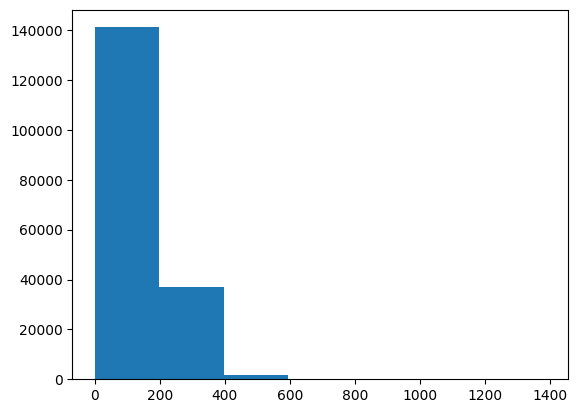

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_len, bins=7);

In [ ]:
# Find what character covers 95% of sequences
int(np.percentile(char_len, 95))

290

In [ ]:
# Get all keyboard characters
import string
characters = string.printable
characters

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [ ]:
# Create a character level tokenizer instance

NUM_CHAR_TOKENS = len(characters)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                output_mode="int",
                                output_sequence_length=290)

In [ ]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab), char_vocab[:5]

(28, ['', '[UNK]', 'e', 't', 'i'])

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=128,
                              mask_zero=True,
                              name="char_embedding")

In [ ]:
inputs = layers.Input(shape=(1, ), dtype="string")
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3.fit(train_char_dataset,
         steps_per_epoch=int(0.1 * len(train_char_dataset)),
         epochs=5,
         validation_data=valid_char_dataset,
         validation_steps=int(0.1 * len(valid_char_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4700 - loss: 1.3005 - val_accuracy: 0.6223 - val_loss: 0.9642
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6253 - loss: 0.9558 - val_accuracy: 0.6695 - val_loss: 0.8725
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6615 - loss: 0.8728 - val_accuracy: 0.6735 - val_loss: 0.8468
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6812 - loss: 0.8393 - val_accuracy: 0.6912 - val_loss: 0.8023
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6904 - loss: 0.8074 - val_accuracy: 0.6912 - val_loss: 0.8117


In [ ]:
model_3_preds = model_3.predict(test_char_dataset)
model_3_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_3_preds.argmax(axis=1))
model_3_results

942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


{'accuracy': 68.6112493777999,
 'precision': 0.7029713914304813,
 'recall': 0.686112493777999,
 'f1': 0.6880592393836645}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid)

In [ ]:
# setup token inputs/model

token_inputs = layers.Input(shape=(1, ), dtype="string", name="token_input")
token_embeddings = embedding_layer(token_inputs)
token_outputs = layers.Dense(128)(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# setup char inputs/model

char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)

# Add a Masking layer to ensure right-padding format for the LSTM
char_embeddings = layers.Masking(mask_value=0)(char_embeddings)

char_bi_lstm = layers.Bidirectional(layers.LSTM(64))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Combine them by using a concatenate layer
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_outputs, char_bi_lstm])

# Adding a dropout layer
combined_dropput = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropput)
final_dropput = layers.Dropout(0.5)(combined_dense)
combined_outputs = layers.Dense(num_classes, activation="softmax")(combined_dense)

# Construct model with char and token level embeddings
model_4 = tf.keras.Model([token_model.input, char_model.input], combined_outputs)

In [ ]:
model_4.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_1      │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 512)            │              0 │ token_input[0][0]      │
│ (EmbeddingLayer)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embedding            │ (None, 290, 128)       │          3,584 │ text_vectorization_1[… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 290)            │              0 │ text_vectorization_1[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         65,664 │ embedding_layer[2][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128)            │         98,816 │ char_embedding[2][0],  │
│ (Bidirectional)           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 256)            │              0 │ dense_5[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 5)              │            645 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 201,605 (787.52 KB)

 Trainable params: 201,605 (787.52 KB)

 Non-trainable params: 0 (0.00 B)

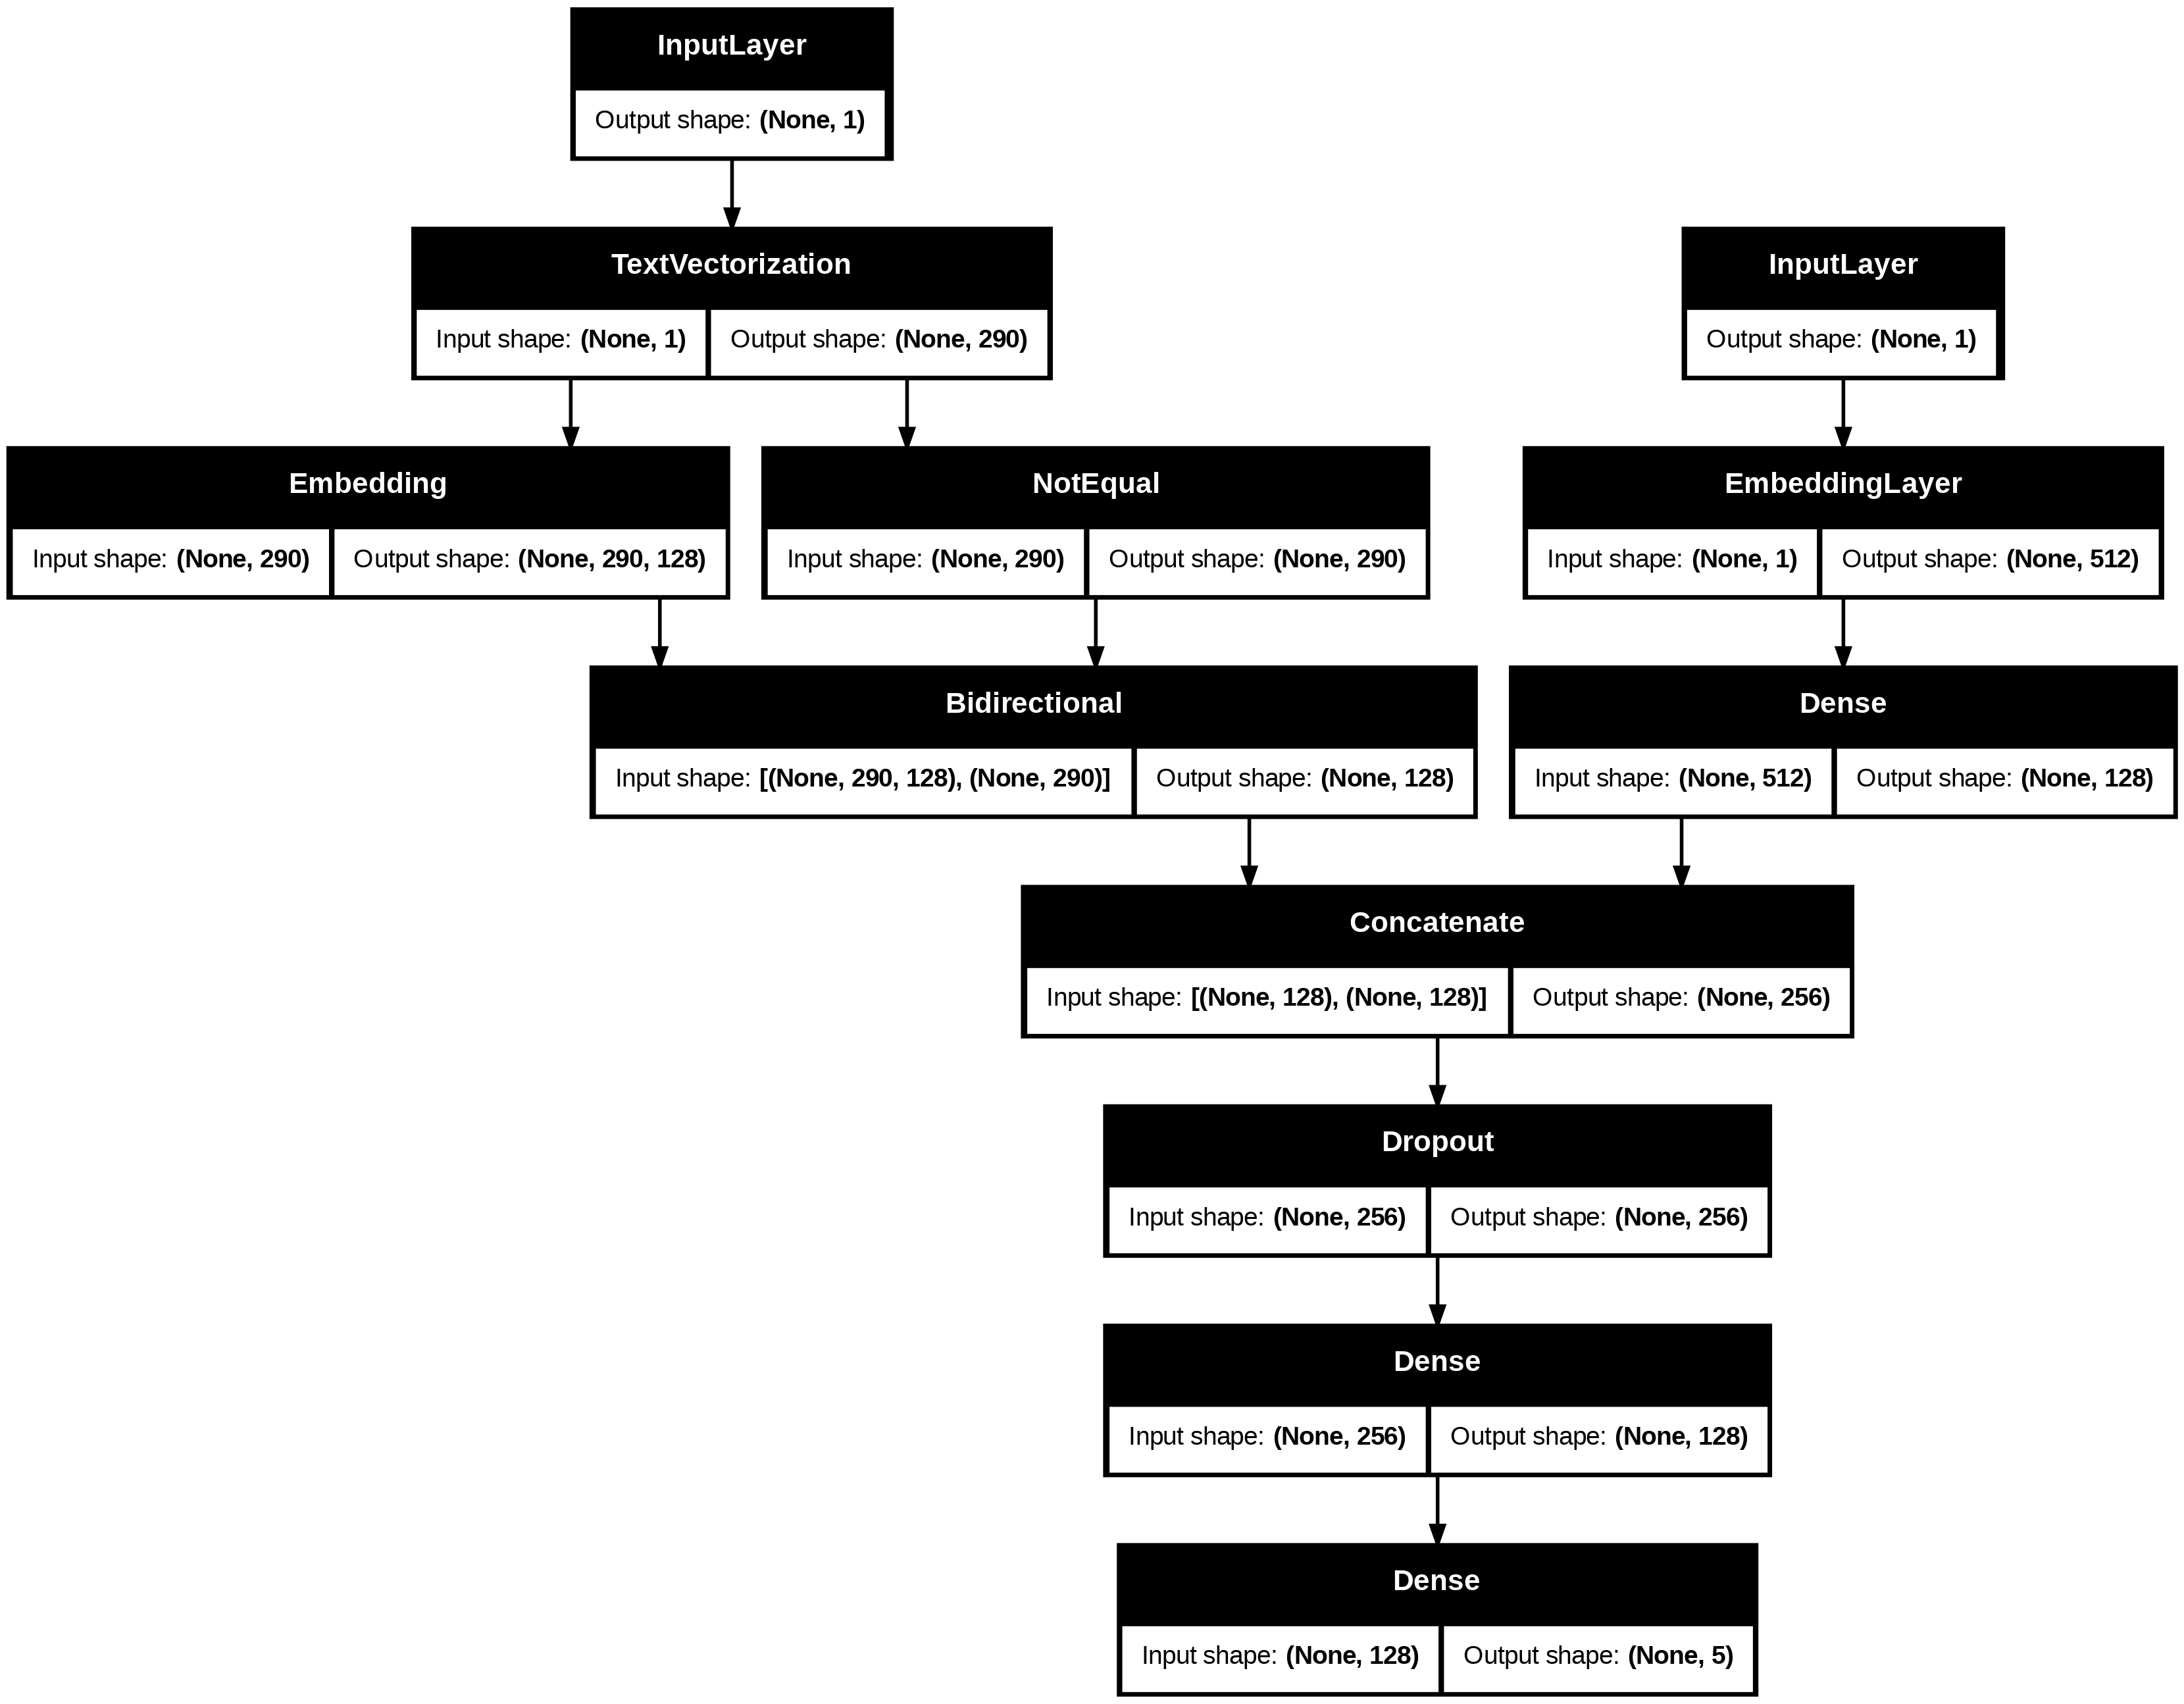

In [ ]:
# plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

### Combining token and character data into a single tf.data dataset

In [ ]:
# combine chars and tokens into a dataset
train_hybrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_hybrid_dataset = tf.data.Dataset.zip((train_hybrid_data, train_hybrid_labels))

# Prefetch and batch data
train_hybrid_dataset = train_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the same steps for validation data
val_hybrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_hybrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_hybrid_dataset = tf.data.Dataset.zip((val_hybrid_data, val_hybrid_labels))

# Prefetch and batch data
val_hybrid_dataset = val_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_hybrid_dataset, val_hybrid_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

**Note**: We need to pass our input data into the model in the same order as we specified during construction of our model

### Fitting our model on token and character-level sequences

In [ ]:
history_4 = model_4.fit(train_hybrid_dataset, steps_per_epoch=int(0.1 * len(train_hybrid_dataset)), epochs=5, validation_data=val_hybrid_dataset, validation_steps=int(0.1 * len(val_hybrid_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.5788 - loss: 1.0479 - val_accuracy: 0.7025 - val_loss: 0.7645
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.7085 - loss: 0.7578 - val_accuracy: 0.7271 - val_loss: 0.7210
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.7127 - loss: 0.7487 - val_accuracy: 0.7330 - val_loss: 0.6883
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.7275 - loss: 0.7092 - val_accuracy: 0.7420 - val_loss: 0.6706
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.7260 - loss: 0.7160 - val_accuracy: 0.7493 - val_loss: 0.6637


In [ ]:
model_4.evaluate(val_hybrid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.7442 - loss: 0.6637


[0.6661261916160583, 0.7448365092277527]

In [ ]:
hybrid_preds = model_4.predict(val_hybrid_dataset)
hybrid_preds

945/945 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step


array([[5.7589823e-01, 2.3722468e-01, 3.0850268e-03, 1.7594132e-01,
        7.8507541e-03],
       [4.8926523e-01, 3.5192534e-01, 1.1603014e-02, 1.4230677e-01,
        4.8996890e-03],
       [4.8436046e-01, 1.1440210e-02, 1.8730780e-02, 4.7786719e-01,
        7.6013594e-03],
       ...,
       [3.6694409e-04, 1.3434020e-03, 2.9286599e-02, 1.6890965e-04,
        9.6883416e-01],
       [3.4541658e-03, 4.3219354e-02, 2.4584195e-01, 1.1853823e-03,
        7.0629919e-01],
       [1.4388737e-01, 4.5266849e-01, 3.6357975e-01, 1.6928790e-03,
        3.8171537e-02]], dtype=float32)

In [ ]:
hybrid_preds = tf.argmax(hybrid_preds, axis=1)
hybrid_preds = hybrid_preds.cpu().numpy()
hybrid_preds

Instructions for updating:
Use tf.identity with explicit device placement instead.


array([0, 0, 0, ..., 4, 4, 1])

In [ ]:
hybrid_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=hybrid_preds)
hybrid_results

{'accuracy': 74.48364888123923,
 'precision': 0.7441867540910342,
 'recall': 0.7448364888123924,
 'f1': 0.7402555261047009}

## Model 5: token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Creating positional embeddings

In [ ]:
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

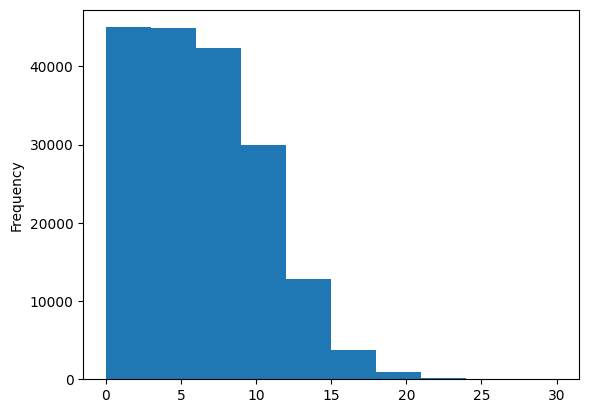

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_df.total_lines.value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

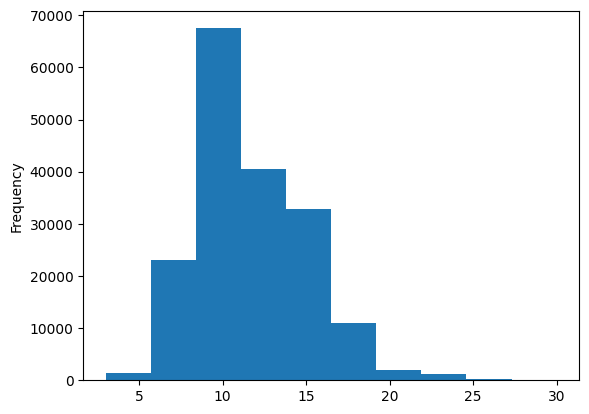

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [ ]:
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 1, 20), dtype=float32, numpy=
 array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0.]],
 
        [[

### Building a tribrid embeddbing model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 and 2 using `layers.Concatenate`
6. Combine the outputs of 3, 4 and 5 using `layers.Concatenate`
7. Create a final dense layer

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_embeddings = layers.Masking(mask_value=0)(char_embeddings)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)


In [ ]:
model_5.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_1      │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 512)            │              0 │ token_inputs[0][0]     │
│ (EmbeddingLayer)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embedding            │ (None, 290, 128)       │          3,584 │ text_vectorization_1[… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_16 (NotEqual)   │ (None, 290)            │              0 │ text_vectorization_1[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 128)            │         65,664 │ embedding_layer[9][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_8           │ (None, 64)             │         41,216 │ char_embedding[9][0],  │
│ (Bidirectional)           │                        │                │ not_equal_16[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid_embedd… │ (None, 192)            │              0 │ dense_38[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 256)            │         49,408 │ token_char_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 32)             │            512 │ line_number_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 32)             │            672 │ total_lines_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 256)            │              0 │ dense_41[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_positional_em… │ (None, 320)            │              0 │ dense_39[0][0],        │
│ (Concatenate)        

 Total params: 162,661 (635.39 KB)

 Trainable params: 162,661 (635.39 KB)

 Non-trainable params: 0 (0.00 B)

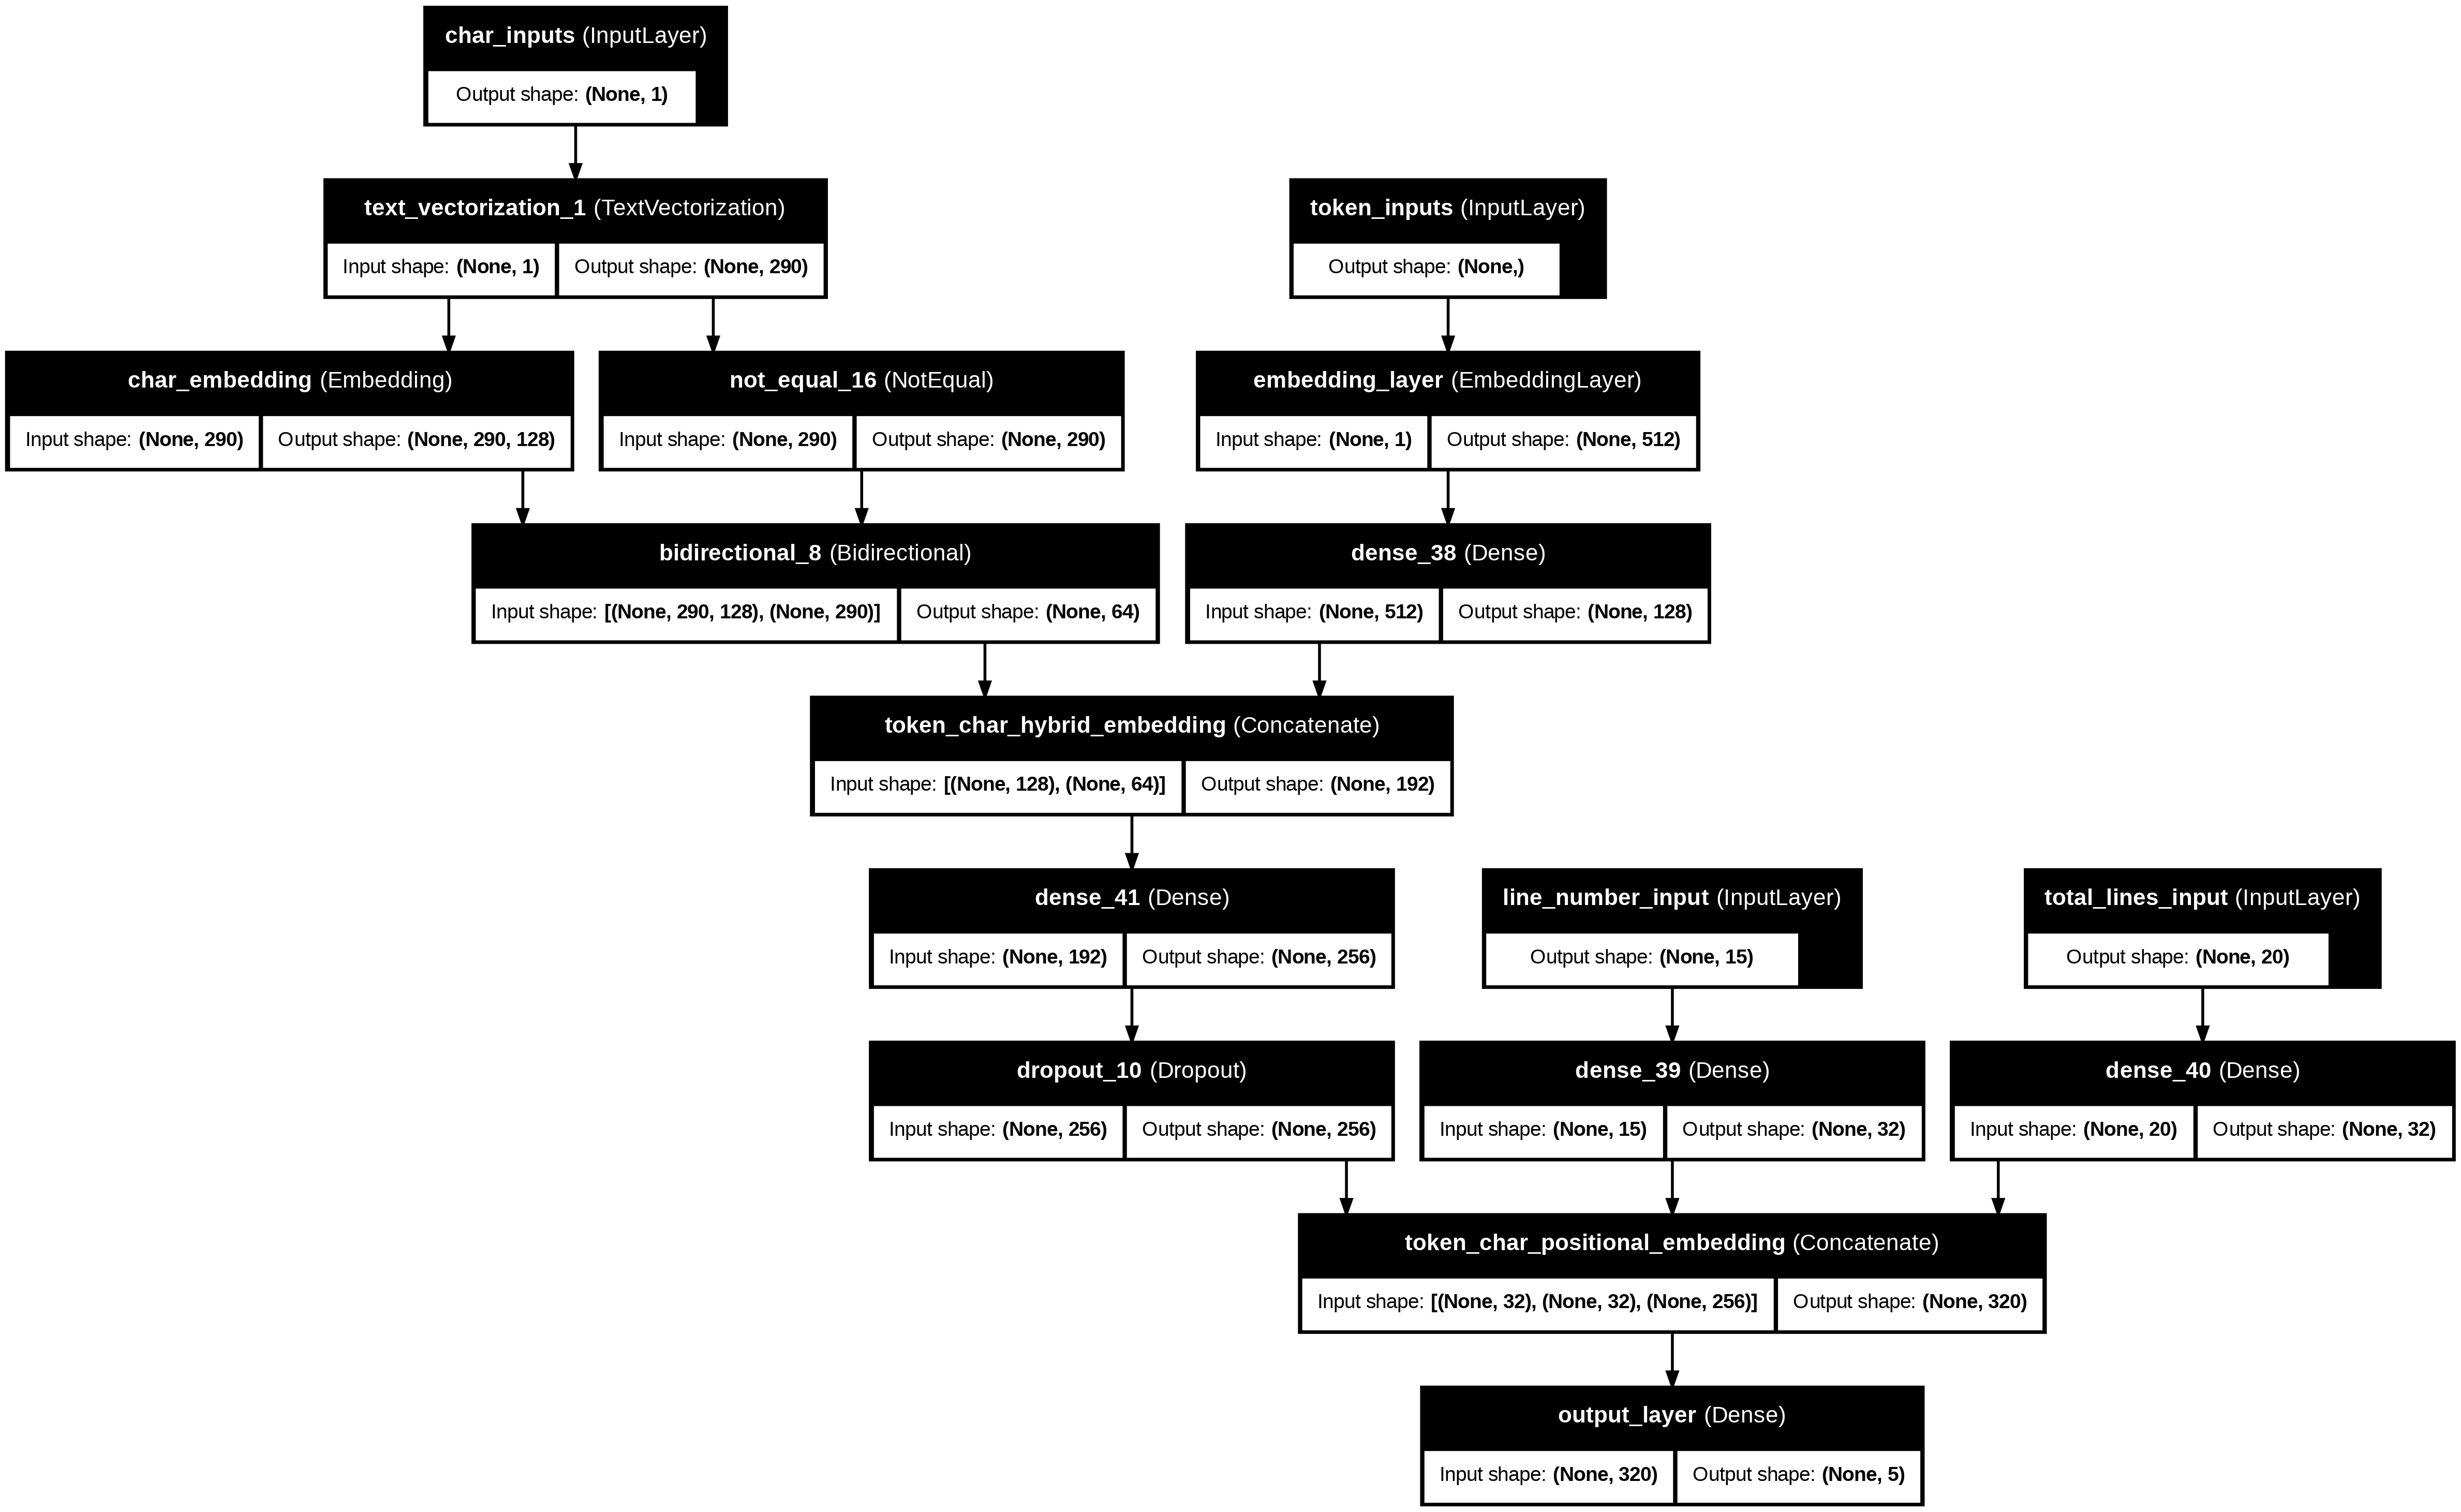

In [ ]:
from keras.utils import plot_model
plot_model(model_5, show_layer_names=True, expand_nested=True, show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # label_smoothing prevents overfitting
                optimizer="adam",
                metrics=["accuracy"])

### Creating tribrid embedding datasets using tf.data

In [ ]:

# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              )

Epoch 1/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 184s 33ms/step - accuracy: 0.8467 - loss: 0.9210 - val_accuracy: 0.8508 - val_loss: 0.9030
Epoch 2/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 185s 33ms/step - accuracy: 0.8587 - loss: 0.9031 - val_accuracy: 0.8564 - val_loss: 0.8964
Epoch 3/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 186s 33ms/step - accuracy: 0.8668 - loss: 0.8929 - val_accuracy: 0.8563 - val_loss: 0.8946
Epoch 4/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 203s 33ms/step - accuracy: 0.8722 - loss: 0.8848 - val_accuracy: 0.8549 - val_loss: 0.8960
Epoch 5/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 191s 34ms/step - accuracy: 0.8767 - loss: 0.8783 - val_accuracy: 0.8546 - val_loss: 0.8963


<Axes: >

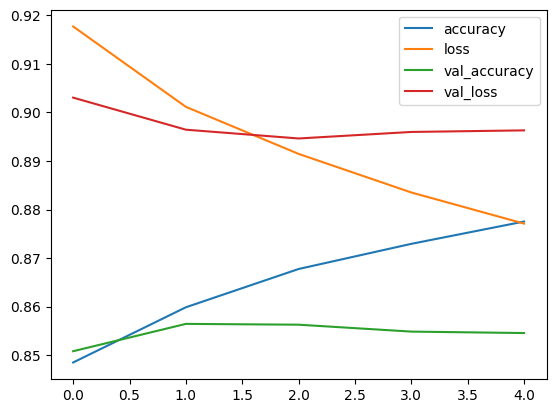

In [ ]:
import pandas as pd
pd.DataFrame(history_model_5.history).plot()